In [1]:
import sys
import warnings
import time
import copy
import json
from datetime import datetime
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from torch.autograd import Function
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import cvxpy as cp

from pyepo.model.opt import optModel
sys.path.insert(0, 'E:\\User\\Stevens\\Code\\The Paper\\algorithm')
from myutil import *
from features import get_all_features

# Suppress warnings
warnings.filterwarnings("ignore")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


Auto-Sklearn cannot be imported.
cuda


# Import and Process Data

In [2]:
alpha, Q = 0.9, 1000


In [3]:
df = pd.read_csv('data/data.csv')
# fix random seed for reproducibility

# report statistics on this dataset
df = df.sample(n=5000, random_state=1)

columns_to_keep = [
    'risk_score_t', 'program_enrolled_t', 'cost_t', 'cost_avoidable_t', 'race', 'dem_female', 'gagne_sum_tm1', 'gagne_sum_t', 
    'risk_score_percentile', 'screening_eligible', 'avoidable_cost_mapped', 'propensity_score', 'g_binary', 
    'g_continuous', 'utility_binary', 'utility_continuous'
]
# for race 0 is white, 1 is black
df_stat = df[columns_to_keep]
df_feature = df[[col for col in df.columns if col not in columns_to_keep]]

# Replace all values less than 0.1 with 0.1
#df['risk_score_t'] = df['risk_score_t'].apply(lambda x: 0.1 if x < 0.1 else x)
df['g_continuous'] = df['g_continuous'].apply(lambda x: 0.1 if x < 0.1 else x)


risk = df['risk_score_t'].values
risk = risk + 0.001 if 0 in risk else risk


feats = df[get_all_features(df)].values
gainF = df['g_continuous'].values
decision = df['propensity_score'].values
cost = np.random.normal(1, 0.5, len(risk)).clip(0.1, 2)
race = df['race'].values

# transform the features
scaler = StandardScaler()
feats = scaler.fit_transform(feats)

from sklearn.model_selection import train_test_split



In [4]:
def AlphaFairness(util, alpha):
    if alpha == 1:
        return np.sum(np.log(util))
    elif alpha == 0:
        return np.sum(util)
    elif alpha == 'inf':
        return np.min(util)
    else:
        return np.sum(util**(1-alpha) / (1-alpha))

def solve_optimization(gainF, risk, cost, alpha=alpha, Q=Q):
    gainF = gainF.detach().cpu().numpy() if isinstance(gainF, torch.Tensor) else gainF
    risk = risk.detach().cpu().numpy() if isinstance(risk, torch.Tensor) else risk
    cost = cost.detach().cpu().numpy() if isinstance(cost, torch.Tensor) else cost

    risk = risk.clip(0.001)
    gainF, risk, cost = gainF.flatten(), risk.flatten(), cost.flatten()
    d = cp.Variable(risk.shape, nonneg=True)

    if gainF.shape != risk.shape or risk.shape != cost.shape:
        raise ValueError("Dimensions of gainF, risk, and cost do not match")

    utils = cp.multiply(cp.multiply(gainF, risk), d)
    constraints = [d >= 0, cp.sum(cost * d) <= Q]

    if alpha == 'inf':
        t = cp.Variable()
        objective = cp.Maximize(t)
        constraints.append(utils >= t)
    elif alpha == 1:
        objective = cp.Maximize(cp.sum(cp.log(utils)))
    elif alpha == 0:
        objective = cp.Maximize(cp.sum(utils))
    else:
        objective = cp.Maximize(cp.sum(utils**(1-alpha)) / (1-alpha))

    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.MOSEK, verbose=False, warm_start=True, mosek_params={'MSK_IPAR_LOG': 1})

    if problem.status != 'optimal':
        print(f"Warning: Problem status is {problem.status}")

    optimal_decision = d.value
    optimal_value = AlphaFairness(optimal_decision * gainF * risk, alpha)

    return optimal_decision, optimal_value


In [5]:
import numpy as np

def solve_closed_form(g, r, c, alpha=alpha, Q=Q):

    g = g.detach().cpu().numpy() if isinstance(g, torch.Tensor) else g
    r = r.detach().cpu().numpy() if isinstance(r, torch.Tensor) else r
    c = c.detach().cpu().numpy() if isinstance(c, torch.Tensor) else c
    if c.shape != r.shape or c.shape != g.shape:
        raise ValueError("c, r, and g must have the same shape.")
    if np.any(c <= 0):
        raise ValueError("All cost values must be positive.")
    if np.any(r <= 0):
        raise ValueError("All risk values must be positive.")
    if np.any(g <= 0):
        raise ValueError("All gain factors must be positive.")
    
    n = len(c)
    utility = r * g
    
    if alpha == 0:
        ratios = utility / c
        sorted_indices = np.argsort(-ratios)  # Descending order
        d_star_closed = np.zeros(n)
        d_star_closed[sorted_indices[0]] = Q / c[sorted_indices[0]]
        
    elif alpha == 1:
        d_star_closed = Q / (n * c)
    
    elif alpha == 'inf':
        d_star_closed = (Q * c) / (utility * np.sum(c * c / utility))
        
    else:
        if alpha <= 0:
            raise ValueError("Alpha must be positive for general case.")
        #
        # d_i* = (c_i^(-1/alpha) * (r_i*g_i)^(1/alpha - 1) * Q) / sum_j(c_j^(-1/alpha) * (r_j*g_j)^(1/alpha - 1))
        
        numerator = np.power(c, -1/alpha) * np.power(utility, 1/alpha - 1)
        denominator = np.sum(numerator)
        
        if denominator == 0:
            raise ValueError("Denominator is zero in closed-form solution.")
            
        d_star_closed = (numerator / denominator) * Q
    
    # if not np.isclose(np.sum(c * d_star_closed), Q, rtol=1e-5):
    #     raise ValueError("Solution does not satisfy budget constraint.")
    obj = AlphaFairness(d_star_closed * utility, alpha)
        
    return d_star_closed, obj

def compute_gradient_closed_form(g, r, c, alpha, Q):
    """
    Compute the analytical gradient of the optimal solution with respect to r.

    This function computes the gradient matrix where each element (i, k) is the partial derivative
    of d_i* with respect to r_k.

    Parameters:
    - g (np.ndarray): Gain factors (g_i), shape (n,)
    - r (np.ndarray): Risk values (r_i), shape (n,)
    - c (np.ndarray): Cost values (c_i), shape (n,)
    - alpha (float or str): Fairness parameter. Can be 0, 1, 'inf', or a positive real number.
    - Q (float): Total budget.

    Returns:
    - gradient (np.ndarray): Gradient matrix of shape (n, n)
    """
    n = len(c)
    gradient = np.zeros((n, n))
    if alpha == 1:
        S = np.sum(c / (r * g))

    elif alpha == 0:
        # Utilitarian case: Allocate everything to the individual with the highest ratio
        ratios = (r * g) / c
        i_star = np.argmax(ratios)
        # Gradient is Q * g_i / c_i at the allocated index, zero elsewhere
        return gradient

    elif alpha == 'inf':
        # Maximin case
        utility = r * g  # Shape: (n,)
        S = np.sum(c**2 / utility)  # Scalar
        if S == 0:
            raise ValueError("Sum S cannot be zero for alpha=inf.")
        
        # Compute d_star
        d_star_closed, _ = solve_closed_form(g, r, c, alpha='inf', Q=Q)  # Shape: (n,)
        
        for i in range(n):
            for k in range(n):
                if k == i:
                    # ∂d_i*/∂r_i = -d_i* / r_i - (d_i* * c_i) / (r_i * g_i * S)
                    gradient[i, k] = -d_star_closed[i] / r[k] - (d_star_closed[i] * c[k]) / (r[k] * g[k] * S)
                else:
                    # ∂d_i*/∂r_k = (d_i* * c_k^2) / (c_i * r_k^2 * g_k * S)
                    gradient[i, k] = (d_star_closed[i] * c[k]**2) / (c[i] * r[k]**2 * g[k] * S)
        return gradient
    else:
        # General alpha case
        if not isinstance(alpha, (int, float)):
            raise TypeError("Alpha must be a positive real number, 0, 1, or 'inf'.")
        if alpha <= 0:
            raise ValueError("Alpha must be positive for gradient computation.")

        # Compute the optimal decision variables
        d_star, _ = solve_closed_form(g, r, c, alpha, Q)  # Shape: (n,)

        # Compute the term (1/alpha - 1) * g / r
        term = (1.0 / alpha - 1.0) * g / r  # Shape: (n,)

        # Compute the outer product for off-diagonal elements
        # Each element (i, k) = -d_star[i] * d_star[k] * term[k] / Q
        gradient = -np.outer(d_star, d_star * term) / Q  # Shape: (n, n)

        # Compute the diagonal elements
        # Each diagonal element (i, i) = d_star[i] * term[i] * (1 - d_star[i]/Q)
        diag_elements = d_star * term * (1 - d_star / Q)  # Shape: (n,)

        # Set the diagonal elements
        np.fill_diagonal(gradient, diag_elements)

        return gradient

In [6]:
def visLearningCurve(loss_log, loss_log_regret, mse_loss_log, fairness_log=None):
    if fairness_log is not None:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 4))
    else:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
    # Plot original loss log
    ax1.plot(loss_log, color="c", lw=2)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Training Loss Curve", fontsize=16)
    ax1.grid(True, alpha=0.3)

    # Plot regret log
    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=2)
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve (Test Regret)", fontsize=16)
    ax2.grid(True, alpha=0.3)

    # Plot MSE loss log
    ax3.plot(mse_loss_log, color="orange", lw=2)
    ax3.tick_params(axis="both", which="major", labelsize=12)
    ax3.set_xlabel("Iters", fontsize=16)
    ax3.set_ylabel("MSE Loss", fontsize=16)
    ax3.set_title("Learning Curve (MSE Loss)", fontsize=16)
    ax3.grid(True, alpha=0.3)

    # Plot fairness log if provided
    if fairness_log is not None:
        ax4.plot(fairness_log, color="green", lw=2)
        ax4.tick_params(axis="both", which="major", labelsize=12)
        ax4.set_xlabel("Iters", fontsize=16)
        ax4.set_ylabel("Fairness", fontsize=16)
        ax4.set_title("Learning Curve (Fairness)", fontsize=16)
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [7]:
class optDataset(Dataset):
    def __init__(self, optmodel, feats, risk, gainF, cost, race, alpha=alpha, Q=Q):
        self.feats = torch.from_numpy(feats).float()
        self.risk = torch.from_numpy(risk).float()
        self.gainF = torch.from_numpy(gainF).float()
        self.cost = torch.from_numpy(cost).float()
        self.race = torch.from_numpy(race).float()
        self.optmodel = optmodel

        # Solve for w*, z* using separate risk and gainF # Ensure a separate instance
        self.w_star, self.z_star = self.optmodel(self.risk, self.gainF, self.cost, alpha=alpha, Q=Q)

        self.w_star = torch.tensor(self.w_star, dtype=torch.float)
        self.z_star = torch.tensor(self.z_star, dtype=torch.float)

    def __len__(self):
        return len(self.feats)

    def __getitem__(self, idx):
        return self.feats, self.risk, self.gainF, self.cost, self.race, self.w_star, self.z_star


In [8]:
class FairRiskPredictor(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.1):
        super().__init__()
        self.model = nn.Sequential(
            # First layer with batch normalization
            nn.Linear(input_dim, 1),
            nn.Softplus()
        )
            
        # # Initialize weights using He initialization
        # for m in self.model:
        #     if isinstance(m, nn.Linear):
        #         nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        #         if m.bias is not None:
        #             nn.init.constant_(m.bias, 0)
                    
    def forward(self, x):
        return self.model(x).squeeze(-1)

In [9]:
def regret(predmodel, optmodel, dataloader, alpha=alpha, Q=Q):
    predmodel.eval()
    feats, risk, gainF, cost, race, opt_sol, opt_val = next(iter(dataloader))

    if torch.cuda.is_available():
        feats, risk, gainF, cost, race, opt_sol, opt_val = feats.cuda(), risk.cuda(), gainF.cuda(), cost.cuda(), race.cuda(), opt_sol.cuda(), opt_val.cuda()

    with torch.no_grad():
        pred_risk = predmodel(feats)

    risk = risk.detach().to('cpu').numpy()
    pred_risk = pred_risk.detach().to('cpu').numpy().flatten()
    pred_risk = pred_risk.clip(min=0.001)
    gainF = gainF.detach().to('cpu').numpy().flatten()
    cost = cost.detach().to('cpu').numpy().flatten()
    pred_sol, _ = optmodel(gainF, pred_risk, cost, alpha, Q)
        
    pred_obj = AlphaFairness(gainF * risk * pred_sol, alpha)

    normalized_regret = (opt_val - pred_obj) / (abs(opt_val) + 1e-7)
    predmodel.train()
    return normalized_regret

In [10]:
class FairRegretLossFunction0(Function):
    @staticmethod
    def forward(ctx, optmodel, cost, gainF, pred_r, true_r, true_sol, true_obj, Q, alpha, race, lambda_fairness, grad_method):
        ctx.grad_method = grad_method
        batch_size = pred_r.size(0)
        losses = torch.zeros(batch_size, device=pred_r.device)
        
        pred_r_np, true_r_np, cost_np, gainF_np = [x.detach().cpu().numpy() for x in [pred_r, true_r, cost, gainF]]
        
        for i in range(batch_size):
            sol, _ = optmodel(gainF_np[i], pred_r_np[i], cost_np[i], alpha, Q)
            obj = AlphaFairness(gainF_np[i] * true_r_np[i] * sol, alpha)
            losses[i] = true_obj[i] - obj
        
        group0_mean, group1_mean = [pred_r[race == g].mean() if (race == g).sum() > 0 else 0 for g in [0, 1]]
        fairness_loss = lambda_fairness * torch.abs(group0_mean - group1_mean)
        
        ctx.save_for_backward(gainF, pred_r, true_r, cost, true_sol, true_obj, race)
        ctx.optmodel, ctx.Q, ctx.alpha, ctx.lambda_fairness, ctx.losses, ctx.group0_mean, ctx.group1_mean, ctx.n0, ctx.n1 = \
            optmodel, Q, alpha, lambda_fairness, losses, group0_mean, group1_mean, (race == 0).sum(), (race == 1).sum()

        return (losses.mean() + fairness_loss).to(pred_r.device)

    @staticmethod
    def backward(ctx, grad_output):
        gainF, pred_r, true_r, cost, true_sol, true_obj, race = ctx.saved_tensors
        optmodel, Q, alpha, lambda_fairness, group0_mean, group1_mean, n0, n1, grad_method = \
            ctx.optmodel, ctx.Q, ctx.alpha, ctx.lambda_fairness, ctx.group0_mean, ctx.group1_mean, ctx.n0, ctx.n1, ctx.grad_method
        
        grad_l_d = (true_r * gainF) ** (1 - alpha) * pred_r ** (-alpha)
        batch_size = pred_r.size(0)
        grad_pred_r = torch.zeros_like(pred_r)

        for i in range(batch_size):
            pred_r_np, cost_np, true_r_np, gainF_np, true_sol_np = [x[i].detach().cpu().numpy() for x in [pred_r, cost, true_r, gainF, true_sol]]
            grad_l_d_i = -torch.tensor(grad_l_d[i], device=pred_r.device, requires_grad=True)

            if grad_method == 'closed_form':
                closed_grad_d_r = torch.tensor(compute_gradient_closed_form(gainF_np, pred_r_np, cost_np, alpha, Q), device=pred_r.device, requires_grad=True)
                grad_pred_r[i] = grad_l_d_i @ closed_grad_d_r

            elif grad_method in ['finite_difference_1', 'finite_difference_2']:
                epsilon = 1e-6
                ptb_r = pred_r_np.copy()
                for k in range(len(ptb_r)):
                    ptb_r[k] += epsilon
                    sol_plus, obj_plus = optmodel(gainF_np, ptb_r, cost_np, alpha, Q)
                    ptb_r[k] -= 2 * epsilon
                    sol_minus, obj_minus = optmodel(gainF_np, ptb_r, cost_np, alpha, Q)
                    
                    if grad_method == 'finite_difference_1':
                        # Correct central difference for sol
                        ptb_grad = (sol_plus - sol_minus) / (2 * epsilon)
                        grad_pred_r[i][k] = grad_l_d_i @ torch.tensor(ptb_grad, device=pred_r.device)
                    
                    elif grad_method == 'finite_difference_2':
                        # Correct central difference for obj
                        ptb_grad = (obj_plus - obj_minus) / (2 * epsilon)
                        grad_pred_r[i][k] = ptb_grad

            if group0_mean != group1_mean:
                for j, race_val in enumerate(race[i]):
                    if race_val == 0 and n0 > 0:
                        grad_pred_r[i][j] += lambda_fairness * torch.sign(group0_mean - group1_mean) / n0
                    elif race_val == 1 and n1 > 0:
                        grad_pred_r[i][j] -= lambda_fairness * torch.sign(group0_mean - group1_mean) / n1

        return None, None, None, grad_output * grad_pred_r, None, None, None, None, None, None, None, None

class FairRegretLoss0(nn.Module):
    def __init__(self, optmodel, Q=Q, alpha=alpha, lambda_fairness=1.0, grad_method='closed_form'):
        super(FairRegretLoss0, self).__init__()
        self.optmodel, self.Q, self.alpha, self.lambda_fairness, self.grad_method = optmodel, Q, alpha, lambda_fairness, grad_method

    def forward(self, gainF, pred_r, true_r, cost, true_sol, true_obj, race):
        return FairRegretLossFunction0.apply(self.optmodel, gainF, cost, pred_r, true_r, true_sol, true_obj, self.Q, self.alpha, race, self.lambda_fairness, self.grad_method)


In [11]:
import torch
from torch.autograd import Function
import torch.nn as nn

class FairRegretLossFunction(Function):
    @staticmethod
    def forward(ctx, optmodel, cost, gainF, pred_r, true_r, true_sol, true_obj, Q, alpha, race, lambda_fairness, grad_method):
        ctx.grad_method = grad_method
        batch_size = pred_r.size(0)
        losses = torch.zeros(batch_size, device=pred_r.device)
        
        pred_r_np, true_r_np, cost_np, gainF_np = [x.detach().cpu().numpy() for x in [pred_r, true_r, cost, gainF]]
        
        for i in range(batch_size):
            sol, _ = optmodel(gainF_np[i], pred_r_np[i], cost_np[i], alpha, Q)
            obj = AlphaFairness(gainF_np[i] * true_r_np[i] * sol, alpha)
            losses[i] = true_obj[i] - obj

        # Compute group-wise MSE
        group0_mask = (race == 0)
        group1_mask = (race == 1)
        n0 = group0_mask.sum().item()
        n1 = group1_mask.sum().item()
        if n0 > 0:
            mse0 = torch.mean((pred_r[group0_mask] - true_r[group0_mask]) ** 2)
        else:
            mse0 = torch.tensor(0.0, device=pred_r.device)
        
        if n1 > 0:
            mse1 = torch.mean((pred_r[group1_mask] - true_r[group1_mask]) ** 2)
        else:
            mse1 = torch.tensor(0.0, device=pred_r.device)
        
        fairness_loss = lambda_fairness * torch.abs(mse0 - mse1)
        mse_diff_sign = (mse0 > mse1).float()

        ctx.save_for_backward(gainF, pred_r, true_r, cost, true_sol, true_obj, race)
        ctx.optmodel, ctx.Q, ctx.alpha, ctx.lambda_fairness, ctx.losses, ctx.group0_mask, ctx.group1_mask, ctx.n0, ctx.n1 = \
            optmodel, Q, alpha, lambda_fairness, losses, group0_mask, group1_mask, torch.tensor(n0, device=pred_r.device), torch.tensor(n1, device=pred_r.device)
        ctx.mse_diff_sign = mse_diff_sign
        return (losses.mean() + fairness_loss).to(pred_r.device)

    @staticmethod
    def backward(ctx, grad_output):
        gainF, pred_r, true_r, cost, true_sol, true_obj, race = ctx.saved_tensors
        optmodel, Q, alpha, lambda_fairness, losses, group0_mask, group1_mask, n0, n1 = \
            ctx.optmodel, ctx.Q, ctx.alpha, ctx.lambda_fairness, ctx.losses, ctx.group0_mask, ctx.group1_mask, ctx.n0, ctx.n1
        mse_diff_sign = ctx.mse_diff_sign
        group0_mask, group1_mask = ctx.group0_mask, ctx.group1_mask

        batch_size = pred_r.size(0)
        grad_pred_r = torch.zeros_like(pred_r)

        # Initialize grad_fairness outside the loop for efficiency
        grad_fairness = torch.zeros_like(pred_r)

        # Compute group-wise MSE gradients
        if n0 > 0:
            grad_fairness[group0_mask] += 2 * (pred_r[group0_mask] - true_r[group0_mask]) / n0
        if n1 > 0:
            grad_fairness[group1_mask] -= 2 * (pred_r[group1_mask] - true_r[group1_mask]) / n1

        # Apply fairness regularization gradient
        grad_fairness = lambda_fairness * torch.sign(mse_diff_sign * 1.0) * grad_fairness

        for i in range(batch_size):
            if alpha == 1:
                # Gradient computation for alpha=1 is not implemented
                # Placeholder: You can implement it similarly based on the specific requirements
                grad_l_d_i = torch.zeros_like(pred_r[i])
            
            elif alpha == 0:
                # For alpha=0, the gradient is -r_i * g_i for each decision variable
                grad_l_d_i = -true_r[i] * gainF[i]
            
            elif alpha == 'inf':
                # For alpha=inf, the gradient is -r_i * g_i for the decision variable with minimum utility
                utilities = true_r[i] * gainF[i] * true_sol[i]
                i_star = torch.argmin(utilities).item()
                grad_l_d_i = torch.zeros_like(true_sol[i])
                grad_l_d_i[i_star] = -true_r[i] * gainF[i][i_star]
            
            else:
                # General case for alpha != 0,1,inf
                grad_l_d_i = (true_r[i] * gainF[i]) ** (1 - alpha) * pred_r[i] ** (-alpha)
                grad_l_d_i = grad_l_d_i.detach()

            # Initialize gradient for this sample
            grad_pred_r_i = torch.zeros_like(pred_r[i])

            if alpha not in [0, 'inf', 1]:
                # Only compute grad_pred_r for the general case
                if ctx.grad_method == 'closed_form':
                    closed_grad_d_r = torch.tensor(
                        compute_gradient_closed_form(gainF[i].detach().cpu().numpy(), 
                                                    pred_r[i].detach().cpu().numpy(), 
                                                    cost[i].detach().cpu().numpy(), 
                                                    alpha, Q),
                        device=pred_r.device
                    )
                    grad_pred_r_i = grad_l_d_i @ closed_grad_d_r
                elif ctx.grad_method in ['finite_difference_1', 'finite_difference_2']:
                    epsilon = 1e-6
                    ptb_r = pred_r[i].detach().cpu().numpy().copy()
                    for k in range(len(ptb_r)):
                        ptb_r[k] += epsilon
                        sol_plus, obj_plus = optmodel(gainF[i].detach().cpu().numpy(), 
                                                     ptb_r, 
                                                     cost[i].detach().cpu().numpy(), 
                                                     alpha, Q)
                        ptb_r[k] -= 2 * epsilon
                        sol_minus, obj_minus = optmodel(gainF[i].detach().cpu().numpy(), 
                                                       ptb_r, 
                                                       cost[i].detach().cpu().numpy(), 
                                                       alpha, Q)
                        
                        if ctx.grad_method == 'finite_difference_1':
                            # Gradient with respect to solution
                            ptb_grad = (sol_plus - sol_minus) / (2 * epsilon)
                            grad_pred_r_i[k] = grad_l_d_i @ torch.tensor(ptb_grad, device=pred_r.device)
                        
                        elif ctx.grad_method == 'finite_difference_2':
                            # Gradient with respect to objective
                            ptb_grad = (obj_plus - obj_minus) / (2 * epsilon)
                            grad_pred_r_i[k] = ptb_grad

            # Accumulate gradients
            grad_pred_r[i] += grad_pred_r_i
            grad_pred_r[i] += grad_fairness[i]

            # For alpha=0 and alpha='inf', additional gradient computations
            if alpha in [0, 'inf']:
                if alpha == 0:
                    # Gradient based on closed-form solution
                    if ctx.grad_method == 'closed_form':
                        closed_grad_d_r = torch.tensor(
                            compute_gradient_closed_form(gainF[i].detach().cpu().numpy(), 
                                                        pred_r[i].detach().cpu().numpy(), 
                                                        cost[i].detach().cpu().numpy(), 
                                                        alpha, Q),
                            device=pred_r.device
                        )
                        grad_pred_r[i] += grad_l_d_i @ closed_grad_d_r
                    elif ctx.grad_method in ['finite_difference_1', 'finite_difference_2']:
                        epsilon = 1e-6
                        ptb_r = pred_r[i].detach().cpu().numpy().copy()
                        for k in range(len(ptb_r)):
                            ptb_r[k] += epsilon
                            sol_plus, obj_plus = optmodel(gainF[i].detach().cpu().numpy(), 
                                                         ptb_r, 
                                                         cost[i].detach().cpu().numpy(), 
                                                         alpha, Q)
                            ptb_r[k] -= 2 * epsilon
                            sol_minus, obj_minus = optmodel(gainF[i].detach().cpu().numpy(), 
                                                           ptb_r, 
                                                           cost[i].detach().cpu().numpy(), 
                                                           alpha, Q)
                            
                            if ctx.grad_method == 'finite_difference_1':
                                # Gradient with respect to solution
                                ptb_grad = (sol_plus - sol_minus) / (2 * epsilon)
                                grad_pred_r[i][k] = grad_l_d_i @ torch.tensor(ptb_grad, device=pred_r.device)
                            
                            elif ctx.grad_method == 'finite_difference_2':
                                # Gradient with respect to objective
                                ptb_grad = (obj_plus - obj_minus) / (2 * epsilon)
                                grad_pred_r[i][k] = ptb_grad

                elif alpha == 'inf':
                    # For alpha=inf, gradient is already set for i_star; no additional computation needed
                    pass

        # Final gradient scaling
        grad_pred_r = grad_pred_r * grad_output

        return (None, None, None, grad_pred_r, None, None, None, None, None, None, None, None)
class FairRegretLoss(nn.Module):
    def __init__(self, optmodel, Q=Q, alpha=alpha, lambda_fairness=1.0, grad_method='closed_form'):
        super(FairRegretLoss, self).__init__()
        self.optmodel, self.Q, self.alpha, self.lambda_fairness, self.grad_method = optmodel, Q, alpha, lambda_fairness, grad_method

    def forward(self, gainF, pred_r, true_r, cost, true_sol, true_obj, race):
        return FairRegretLossFunction.apply(self.optmodel, gainF, cost, pred_r, true_r, true_sol, true_obj, self.Q, self.alpha, race, self.lambda_fairness, self.grad_method)


In [12]:
class FairMSELoss0(nn.Module):
    def __init__(self, lambda_fairness=1.0):
        super(FairMSELoss0, self).__init__()
        self.mse = nn.MSELoss()
        self.lambda_fairness = lambda_fairness

    def forward(self, pred, target, race):
        mse_loss = self.mse(pred, target)
        group_means = [pred[race == g].mean() if (race == g).sum() > 0 else 0 for g in [0, 1]]
        fairness_loss = torch.abs(group_means[0] - group_means[1])
        return mse_loss + self.lambda_fairness * fairness_loss


In [13]:
class FairMSELoss(nn.Module):
    def __init__(self, lambda_fairness=1.0):
        super(FairMSELoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.lambda_fairness = lambda_fairness

    def forward(self, pred_r, true_r, race):
        """
        Computes the MSE loss with an added fairness term based on accuracy parity.

        Args:
            pred_r (Tensor): Predicted risk scores.
            true_r (Tensor): True risk scores.
            race (Tensor): Binary tensor indicating group membership (0 or 1).

        Returns:
            Tensor: Combined loss (MSE + fairness penalty).
        """
        # Compute standard MSE loss
        mse = self.mse_loss(pred_r, true_r)
        
        # Compute group-wise MSE
        group0_mask = (race == 0)
        group1_mask = (race == 1)
        n0 = group0_mask.sum().item()
        n1 = group1_mask.sum().item()
        
        if n0 > 0:
            mse0 = torch.mean((pred_r[group0_mask] - true_r[group0_mask]) ** 2)
        else:
            mse0 = torch.tensor(0.0, device=pred_r.device)
        
        if n1 > 0:
            mse1 = torch.mean((pred_r[group1_mask] - true_r[group1_mask]) ** 2)
        else:
            mse1 = torch.tensor(0.0, device=pred_r.device)
        
        # Compute accuracy parity fairness term
        fairness_loss = self.lambda_fairness * torch.abs(mse0 - mse1)
        
        # Total loss
        total_loss = mse + fairness_loss
        
        return total_loss

In [14]:
def trainFairModel(predmodel, optmodel, loader_train, loader_test, lambda_fairness, 
                num_epochs=10, initial_lr=1e-3, weight_decay=1e-4, alpha=alpha, Q=Q, 
                dfl=True, grad_method='closed_form', scheduler_patience=5, 
                scheduler_factor=0.5, min_lr=1e-6):
    """
    Enhanced training function with adaptive learning rate and weight decay
    
    Args:
        predmodel: Prediction model to train
        optmodel: Optimization model
        loader_train: Training data loader
        loader_test: Test data loader
        lambda_fairness: Fairness penalty coefficient
        num_epochs: Number of training epochs
        initial_lr: Initial learning rate
        weight_decay: L2 regularization factor
        alpha: Alpha parameter for fairness
        Q: Q parameter
        dfl: Whether to use DFL loss
        grad_method: Gradient computation method
        scheduler_patience: Number of epochs to wait before reducing LR
        scheduler_factor: Factor by which to reduce LR
        min_lr: Minimum learning rate
    """
    # Initialize optimizer with weight decay
    optimizer = torch.optim.Adam(predmodel.parameters(), lr=initial_lr, weight_decay=weight_decay)
    
    # Initialize learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=scheduler_factor,
        patience=scheduler_patience,
        verbose=True,
        min_lr=min_lr
    )
    
    loss_func = FairRegretLoss(optmodel, Q=Q, alpha=alpha, lambda_fairness=lambda_fairness, grad_method=grad_method)
    fair_mse_loss_func = FairMSELoss(lambda_fairness=lambda_fairness)
    mse_loss_func = nn.MSELoss()

    train_loss_log = []
    test_regret_log = []
    test_mse_log = []
    test_fair_log = []
    best_regret = float('inf')
    best_model_state = None
    elapsed = 0

    init_regret = regret(predmodel, optmodel, loader_test, alpha=alpha, Q=Q)
    # print(f'Initial test regret: {float(init_regret):.4f}')
    # print(f'Initial learning rate: {initial_lr}')

    for epoch in range(num_epochs):
        tick = time.time()
        predmodel.train()
        
        # Get batch data
        feats, risk, gainF, cost, race, opt_sol, opt_val = next(iter(loader_train))
        if torch.cuda.is_available():
            feats, risk, gainF, cost, race, opt_sol, opt_val = [
                x.cuda() for x in [feats, risk, gainF, cost, race, opt_sol, opt_val]
            ]

        # Forward pass
        pred_risk = predmodel(feats).clip(min=0.001)
        loss = loss_func(gainF, pred_risk, risk, cost, opt_sol, opt_val, race)
        mse_loss = mse_loss_func(pred_risk, risk)
        fair_mse_loss = fair_mse_loss_func(pred_risk, risk, race)

        # Backward pass
        optimizer.zero_grad()
        (loss if dfl else fair_mse_loss).backward()
        optimizer.step()

        # Compute fairness metric (accuracy parity: difference in MSE between groups)
        group0_mask = (race == 0)
        group1_mask = (race == 1)
        n0 = group0_mask.sum().item()
        n1 = group1_mask.sum().item()
        
        if n0 > 0:
            mse0 = torch.mean((pred_risk[group0_mask] - risk[group0_mask]) ** 2).item()
        else:
            mse0 = 0.0
        
        if n1 > 0:
            mse1 = torch.mean((pred_risk[group1_mask] - risk[group1_mask]) ** 2).item()
        else:
            mse1 = 0.0
        fairness_metric = abs(mse0 - mse1)
        # Calculate test regret
        current_regret = float(regret(predmodel, optmodel, loader_test, alpha=alpha, Q=Q))
        
        # Save best model
        if current_regret < best_regret:
            best_regret = current_regret
            best_model_state = copy.deepcopy(predmodel.state_dict())

        # Update learning rate
        scheduler.step(current_regret)
        current_lr = optimizer.param_groups[0]['lr']

        # Log metrics
        elapsed += time.time() - tick
        train_loss_log.append(float(loss))
        test_mse_log.append(float(mse_loss))
        test_fair_log.append(fairness_metric)
        test_regret_log.append(current_regret)

        # if epoch % 20 == 0:
        #     print(f"Epoch {epoch+1:2}, LR:{current_lr:.2e}, MSE:{float(mse_loss):.4f}, "
        #           f"Loss:{float(loss):.4f}, Fairness:{fairness_metric:.4f}, "
        #           f"Regret:{current_regret:.4f}%, Time:{elapsed:.2f}s")

        # Early stopping check
        if current_lr <= min_lr:
            # print(f"Learning rate {current_lr} below minimum threshold. Stopping early.")
            break

    # Restore best model
    if best_model_state is not None:
        predmodel.load_state_dict(best_model_state)
        # print(f"Restored best model with regret: {best_regret:.4f}")
    
    predmodel.eval()
    return test_regret_log, train_loss_log, test_mse_log, test_fair_log

In [15]:
optmodel = solve_closed_form

# Perform train-test split
feats_train, feats_test, gainF_train, gainF_test, risk_train, risk_test, cost_train, cost_test, race_train, race_test = train_test_split(
    feats, gainF, risk, cost, df['race'].values, test_size=0.5, random_state=2
)

print(f"Train size: {feats_train.shape[0]}")
print(f"Test size: {feats_test.shape[0]}")

Train size: 2500
Test size: 2500


In [16]:
dataset_train = optDataset(optmodel, feats_train, risk_train, gainF_train, cost_train, race_train, alpha=alpha, Q=Q)
dataset_test = optDataset(optmodel, feats_test, risk_test, gainF_test, cost_test, race_test, alpha=alpha, Q=Q)

# Create dataloaders
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

predmodel = FairRiskPredictor(feats_train.shape[1])
predmodel.to(device)
# save the initial model
torch.save(predmodel.state_dict(), 'initial_model.pth')
# load the initial model


# Test the training pipeline

In [17]:
alpha = 0.9

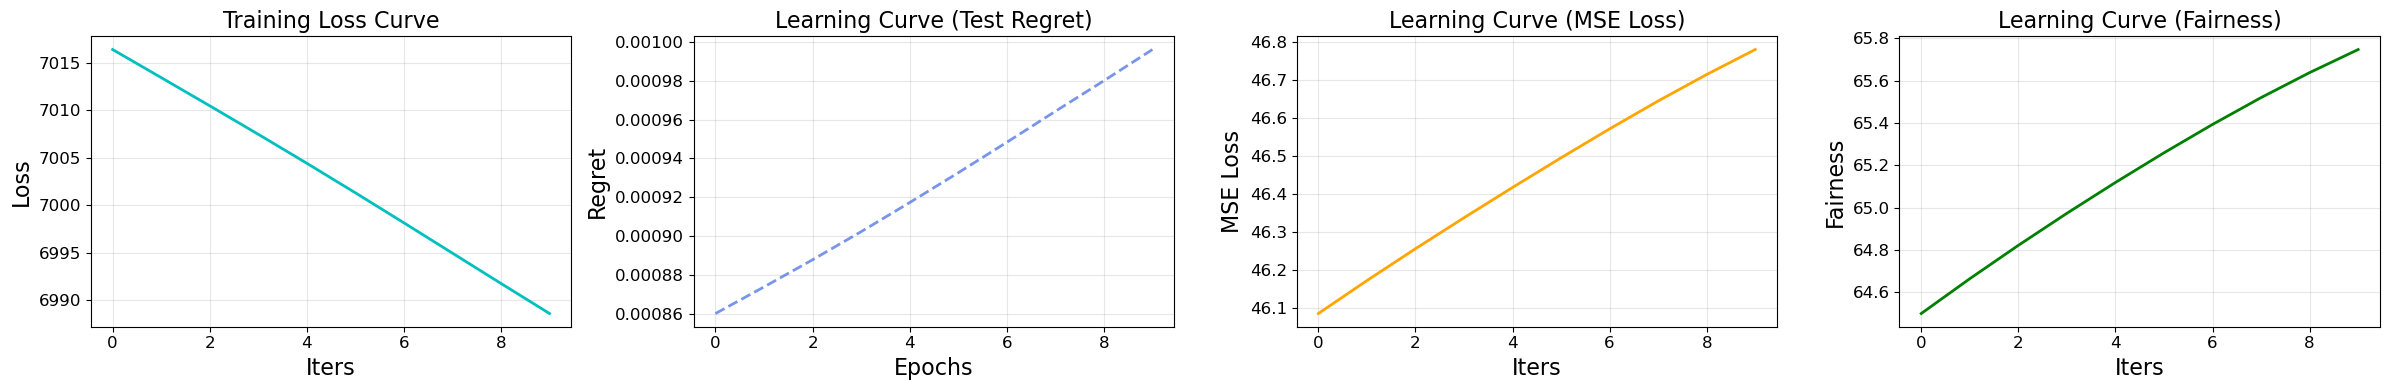

In [18]:
predmodel = FairRiskPredictor(feats_train.shape[1])
predmodel.load_state_dict(torch.load('initial_model.pth'))
predmodel.to(device)

test_regret_log, train_loss_log, test_mse_log, test_fair_log = trainFairModel(
    predmodel=predmodel,
    optmodel=solve_closed_form,
    loader_train=dataloader_train,
    loader_test=dataloader_test,
    lambda_fairness=0.01,
    num_epochs=10,
    initial_lr=1e-3,
    weight_decay=1e-4,
    scheduler_patience=10,
    scheduler_factor=0.5,
    min_lr=1e-4,
    dfl=True,
    grad_method='closed_form'
)


train_loss_log_values = [loss for loss in train_loss_log]
test_regret_log_values = [regret for regret in test_regret_log]
mse_loss_log_values = [mse for mse in test_mse_log]
fairness_log_values = [fair for fair in test_fair_log]
visLearningCurve(
    train_loss_log_values,
    test_regret_log_values,
    mse_loss_log_values,
    fairness_log_values
)

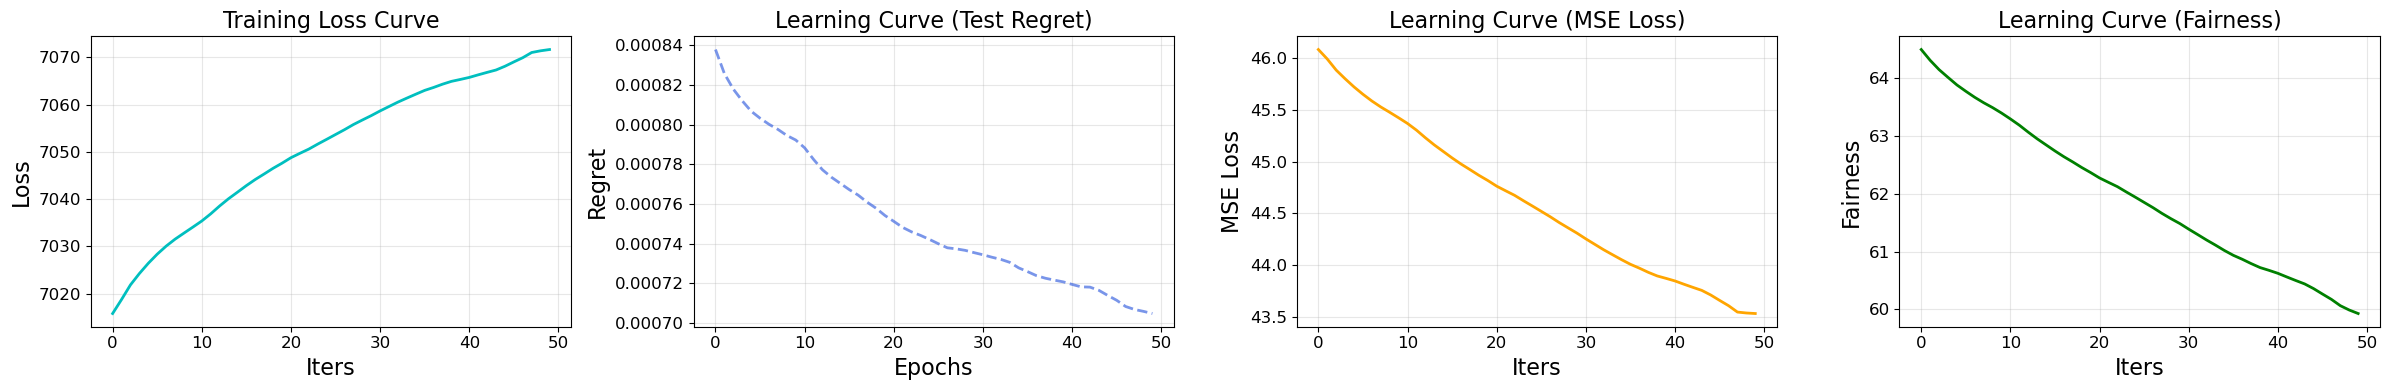

In [19]:
predmodel = FairRiskPredictor(feats_train.shape[1])
predmodel.load_state_dict(torch.load('initial_model.pth'))
predmodel.to(device)

test_regret_log, train_loss_log, test_mse_log, test_fair_log = trainFairModel(
    predmodel=predmodel,
    optmodel=solve_closed_form,
    loader_train=dataloader_train,
    loader_test=dataloader_test,
    lambda_fairness=0,
    num_epochs=50,
    initial_lr=1e-3,
    weight_decay=1e-4,
    scheduler_patience=10,
    scheduler_factor=0.5,
    min_lr=1e-4,
    dfl=True,
    grad_method='finite_difference_2'
)


train_loss_log_values = [loss for loss in train_loss_log]
test_regret_log_values = [regret for regret in test_regret_log]
mse_loss_log_values = [mse for mse in test_mse_log]
fairness_log_values = [fair for fair in test_fair_log]
visLearningCurve(
    train_loss_log_values,
    test_regret_log_values,
    mse_loss_log_values,
    fairness_log_values
)

In [20]:
# import optuna

# def objective(trial):
#     # Define the search space
#     num_epochs = trial.suggest_int("num_epochs", 20, 100)
#     initial_lr = trial.suggest_loguniform("initial_lr", 1e-5, 1e-2)
#     weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
#     scheduler_patience = trial.suggest_int("scheduler_patience", 5, 20)
#     scheduler_factor = trial.suggest_float("scheduler_factor", 0.1, 0.9)
#     min_lr = trial.suggest_loguniform("min_lr", 1e-6, 1e-4)
    
#     # Train the model
#     test_regret_log, _, test_mse_log, _ = trainFairModel(
#         predmodel=predmodel,
#         optmodel=solve_closed_form,
#         loader_train=dataloader_train,
#         loader_test=dataloader_test,
#         lambda_fairness=0,
#         num_epochs=num_epochs,
#         dfl=True,
#         initial_lr=initial_lr,
#         weight_decay=weight_decay,
#         scheduler_patience=scheduler_patience,
#         scheduler_factor=scheduler_factor,
#         min_lr=min_lr
#     )
    
#     # Return the metric to minimize
#     return min(test_regret_log)

# # Run the study
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=50)

# # Print best hyperparameters
# print("Best hyperparameters:", study.best_params)


Best hyperparameters for 2-stage: {'num_epochs': 31, 'initial_lr': 0.009319579012502613, 'weight_decay': 1.6119280526575763e-06, 'scheduler_patience': 12, 'scheduler_factor': 0.7286844843428214, 'min_lr': 1.1984573334930653e-06}

In [21]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def run_multiple_trials(optmodel, feats, gainF, risk, cost, df, n_trials=10, test_size=0.5, 
                       lambda_fairness=0, num_epochs=50, initial_lr=5e-3, 
                       weight_decay=1e-4, scheduler_patience=5, scheduler_factor=0.5, 
                       min_lr=1e-6, alpha=0.5, Q=1000, dfl=False, grad_method='closed_form', device='cuda'):
    """
    Run multiple trials with different random splits and return average results
    """
    # Initialize lists to store results from all trials
    all_train_loss = []
    all_test_regret = []
    all_test_mse = []
    all_test_fair = []
    all_train_time = []

    total_time = time.time()
    
    for trial in range(n_trials):
        print(f"\nRunning trial {trial + 1}/{n_trials}")
        trial_start_time = time.time()
        
        # Perform train-test split with different random state for each trial
        split_vars = train_test_split(
            feats, gainF, risk, cost, df['race'].values,
            test_size=test_size, random_state=trial
        )
        
        (feats_train, feats_test, gainF_train, gainF_test, risk_train, risk_test,
         cost_train, cost_test, race_train, race_test) = split_vars
        
        # Create datasets
        dataset_train = optDataset(optmodel, feats_train, risk_train, 
                                 gainF_train, cost_train, race_train, alpha=alpha, Q=Q)
        dataset_test = optDataset(optmodel, feats_test, risk_test, 
                                gainF_test, cost_test, race_test, alpha=alpha, Q=Q)
        
        # Create dataloaders
        dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=False)
        dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)
        
        # Initialize model
        predmodel = FairRiskPredictor(feats_train.shape[1])
        # predmodel.load_state_dict(torch.load('initial_model.pth'))
        predmodel.to(device)
        
        # Train model
        results = trainFairModel(
            predmodel=predmodel,
            optmodel=optmodel,
            loader_train=dataloader_train,
            loader_test=dataloader_test,
            lambda_fairness=lambda_fairness,
            num_epochs=num_epochs,
            initial_lr=initial_lr,
            weight_decay=weight_decay,
            alpha=alpha,
            Q=Q,
            dfl=dfl,
            grad_method=grad_method,
            scheduler_patience=scheduler_patience,
            scheduler_factor=scheduler_factor,
            min_lr=min_lr
        )
        
        test_regret_log, train_loss_log, test_mse_log, test_fair_log = results
        
        # Store results
        all_train_loss.append(train_loss_log)
        all_test_regret.append(test_regret_log)
        all_test_mse.append(test_mse_log)
        all_test_fair.append(test_fair_log)

        trial_time = time.time() - trial_start_time
        all_train_time.append(trial_time)

    total_times = time.time() - total_time
    mean_time = np.mean(all_train_time)
    std_time = np.std(all_train_time)

    print(f"\nAll trials completed in {total_times:.2f} seconds")
    print(f"Mean trial time: {mean_time:.2f} ± {std_time:.2f} seconds")

    # Convert to numpy arrays for easier manipulation
    all_train_loss = np.array(all_train_loss)
    all_test_regret = np.array(all_test_regret)
    all_test_mse = np.array(all_test_mse)
    all_test_fair = np.array(all_test_fair)
    
    # Calculate means
    mean_train_loss = np.mean(all_train_loss, axis=0)
    mean_test_regret = np.mean(all_test_regret, axis=0)
    mean_test_mse = np.mean(all_test_mse, axis=0)
    mean_test_fair = np.mean(all_test_fair, axis=0)
    
    # Calculate standard deviations for shaded regions
    std_train_loss = np.std(all_train_loss, axis=0)
    std_test_regret = np.std(all_test_regret, axis=0)
    std_test_mse = np.std(all_test_mse, axis=0)
    std_test_fair = np.std(all_test_fair, axis=0)

    # Create figure with both mean curves and confidence intervals
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 4))
    
    epochs = range(len(mean_train_loss))
    
    # Training Loss
    ax1.plot(mean_train_loss, color="c", lw=2, label='Mean')
    ax1.fill_between(epochs, mean_train_loss - std_train_loss, 
                    mean_train_loss + std_train_loss, 
                    color="c", alpha=0.2, label='±1 std')
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title(f"Training Loss Curve (avg of {n_trials} trials)", fontsize=16)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Test Regret
    ax2.plot(mean_test_regret, color="royalblue", ls="--", alpha=0.7, lw=2, label='Mean')
    ax2.fill_between(epochs, mean_test_regret - std_test_regret,
                    mean_test_regret + std_test_regret,
                    color="royalblue", alpha=0.2, label='±1 std')
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title(f"Learning Curve (Test Regret, avg of {n_trials} trials)", fontsize=16)
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # MSE Loss
    ax3.plot(mean_test_mse, color="orange", lw=2, label='Mean')
    ax3.fill_between(epochs, mean_test_mse - std_test_mse,
                    mean_test_mse + std_test_mse,
                    color="orange", alpha=0.2, label='±1 std')
    ax3.tick_params(axis="both", which="major", labelsize=12)
    ax3.set_xlabel("Iters", fontsize=16)
    ax3.set_ylabel("MSE Loss", fontsize=16)
    ax3.set_title(f"Learning Curve (MSE Loss, avg of {n_trials} trials)", fontsize=16)
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    # Fairness
    ax4.plot(mean_test_fair, color="green", lw=2, label='Mean')
    ax4.fill_between(epochs, mean_test_fair - std_test_fair,
                    mean_test_fair + std_test_fair,
                    color="green", alpha=0.2, label='±1 std')
    ax4.tick_params(axis="both", which="major", labelsize=12)
    ax4.set_xlabel("Iters", fontsize=16)
    ax4.set_ylabel("Fairness", fontsize=16)
    ax4.set_title(f"Learning Curve (Fairness, avg of {n_trials} trials)", fontsize=16)
    ax4.grid(True, alpha=0.3)
    ax4.legend()

    plt.tight_layout()
    plt.show()
    
    # Return mean results
    return {
        'mean_train_loss': mean_train_loss,
        'mean_test_regret': mean_test_regret,
        'mean_test_mse': mean_test_mse,
        'mean_test_fair': mean_test_fair,
        'std_train_loss': std_train_loss,
        'std_test_regret': std_test_regret,
        'std_test_mse': std_test_mse,
        'std_test_fair': std_test_fair,
        'total_times': total_times,
        'mean_time': mean_time,
        'std_time': std_time,
        'all_train_time': all_train_time,
    }

In [22]:
alpha = 0.5
print(f"Running with alpha={alpha}")
Q = 1000


Running with alpha=0.5


# This is the results for `2-stage` with `lambda_fairness` = 0


Running trial 1/10
Epoch 00022: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00033: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00044: reducing learning rate of group 0 to 2.5000e-04.

Running trial 2/10
Epoch 00022: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00033: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00044: reducing learning rate of group 0 to 2.5000e-04.

Running trial 3/10
Epoch 00019: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00030: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00041: reducing learning rate of group 0 to 2.5000e-04.

Running trial 4/10
Epoch 00027: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00038: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00049: reducing learning rate of group 0 to 2.5000e-04.

Running trial 5/10
Epoch 00019: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00030: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00041: reducing learning r

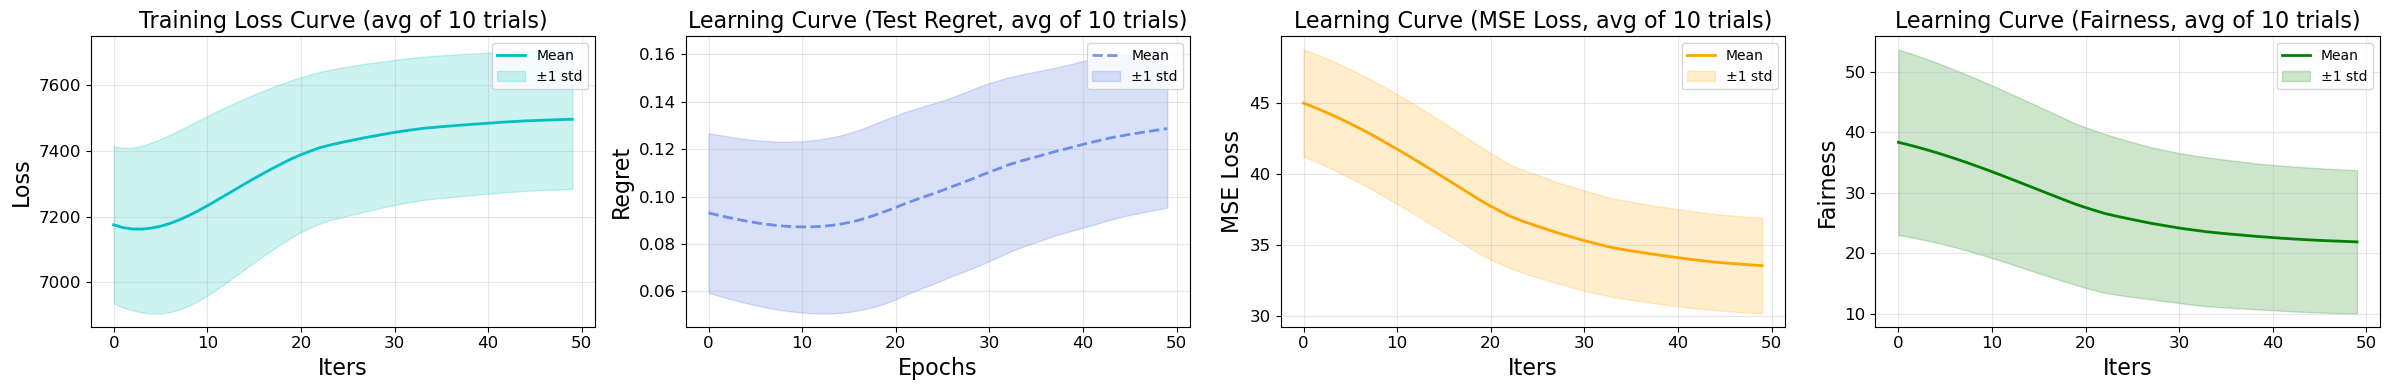

In [23]:
results_pfl_no_fair = run_multiple_trials(
    optmodel=solve_closed_form,
    feats=feats,
    gainF=gainF,
    risk=risk,
    cost=cost,
    df=df,
    n_trials=10,
    lambda_fairness=0,
    num_epochs=50,
    initial_lr=2e-3,
    weight_decay=1e-4,
    scheduler_patience=10,
    scheduler_factor=0.5,
    min_lr=1e-4,
    alpha=alpha,
    Q=Q,
    dfl=False,
    grad_method='closed_form'
)

# This is the result for `2-stage` with `fair prediction` `lambda_fairness`=1


Running trial 1/10
Epoch 00030: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00041: reducing learning rate of group 0 to 5.0000e-04.

Running trial 2/10
Epoch 00025: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00036: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00047: reducing learning rate of group 0 to 2.5000e-04.

Running trial 3/10

Running trial 4/10
Epoch 00012: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00023: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00034: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00045: reducing learning rate of group 0 to 1.2500e-04.

Running trial 5/10
Epoch 00013: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00024: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00035: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00046: reducing learning rate of group 0 to 1.2500e-04.

Running trial 6/10
Epoch 00036: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00047:

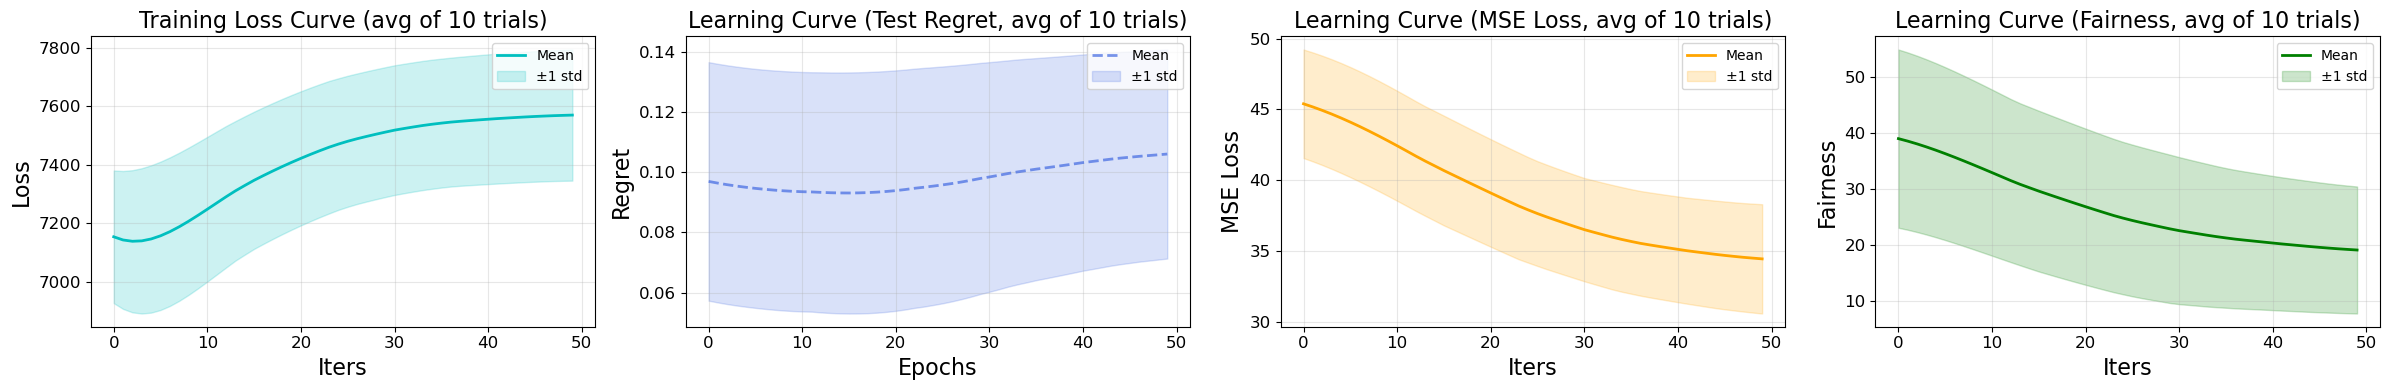

In [24]:
results_pfl_with_fair = run_multiple_trials(
    optmodel=solve_closed_form,
    feats=feats,
    gainF=gainF,
    risk=risk,
    cost=cost,
    df=df,
    n_trials=10,
    lambda_fairness=1,
    num_epochs=50,
    initial_lr=2e-3,
    weight_decay=1e-4,
    scheduler_patience=10,
    scheduler_factor=0.5,
    min_lr=1e-4,
    alpha=alpha,
    Q=Q,
    dfl=False,
    grad_method='closed_form'
)

# This is the result for `normal prediction` with `DFL` using `Closed form solution` with `lambda_fairness`=0


Running trial 1/10
Epoch 00012: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00023: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00034: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00045: reducing learning rate of group 0 to 1.2500e-04.

Running trial 2/10
Epoch 00012: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00023: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00034: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00045: reducing learning rate of group 0 to 1.2500e-04.

Running trial 3/10
Epoch 00012: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00023: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00034: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00045: reducing learning rate of group 0 to 1.2500e-04.

Running trial 4/10
Epoch 00012: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00023: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00034: reducing learning rate of group 0 to 2.

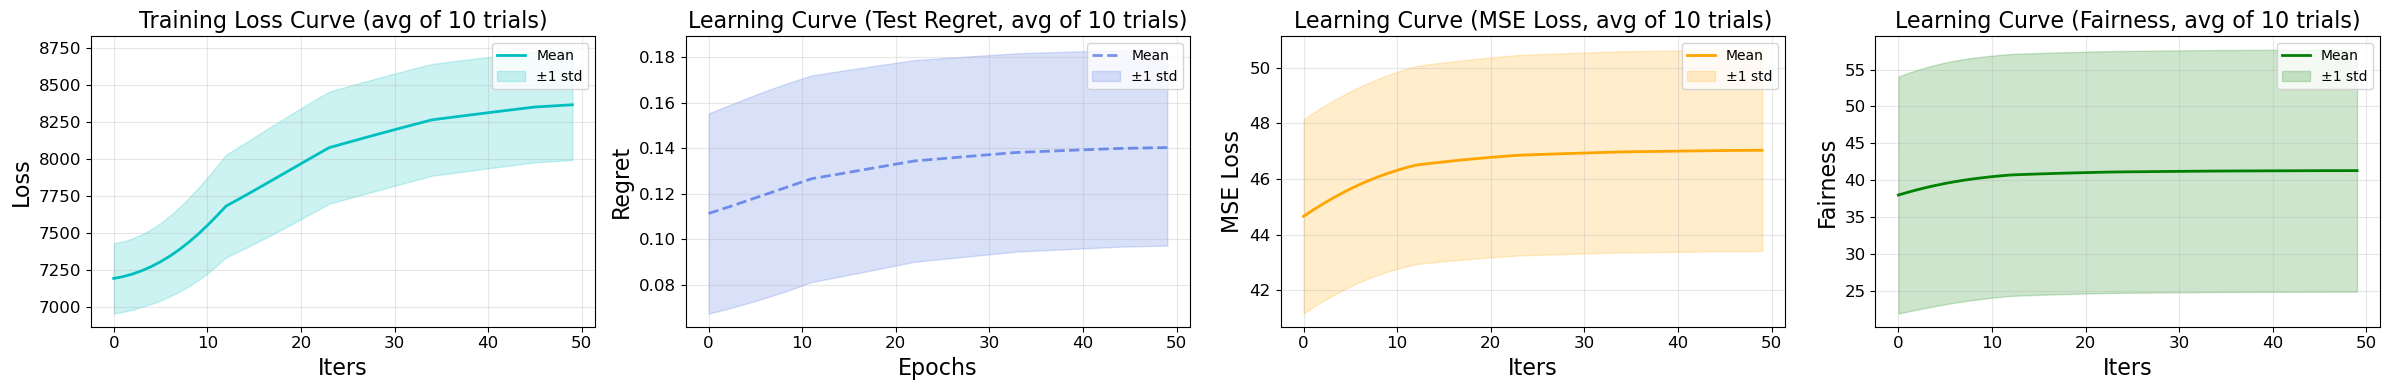

In [25]:
results_dfl_no_fair = run_multiple_trials(
    optmodel=solve_closed_form,
    feats=feats,
    gainF=gainF,
    risk=risk,
    cost=cost,
    df=df,
    n_trials=10,
    lambda_fairness=0,
    num_epochs=50,
    initial_lr=2e-3,
    weight_decay=1e-4,
    scheduler_patience=10,
    scheduler_factor=0.5,
    min_lr=1e-4,
    alpha=alpha,
    Q=Q,
    dfl=True,
    grad_method='closed_form'
)

# This is the result for `fair prediction` with `DFL` using `Closed form solution` with `lambda_fairness`=1


Running trial 1/10
Epoch 00012: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00023: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00034: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00045: reducing learning rate of group 0 to 1.2500e-04.

Running trial 2/10
Epoch 00012: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00023: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00034: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00045: reducing learning rate of group 0 to 1.2500e-04.

Running trial 3/10
Epoch 00012: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00023: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00034: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00045: reducing learning rate of group 0 to 1.2500e-04.

Running trial 4/10
Epoch 00012: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00023: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00034: reducing learning rate of group 0 to 2.

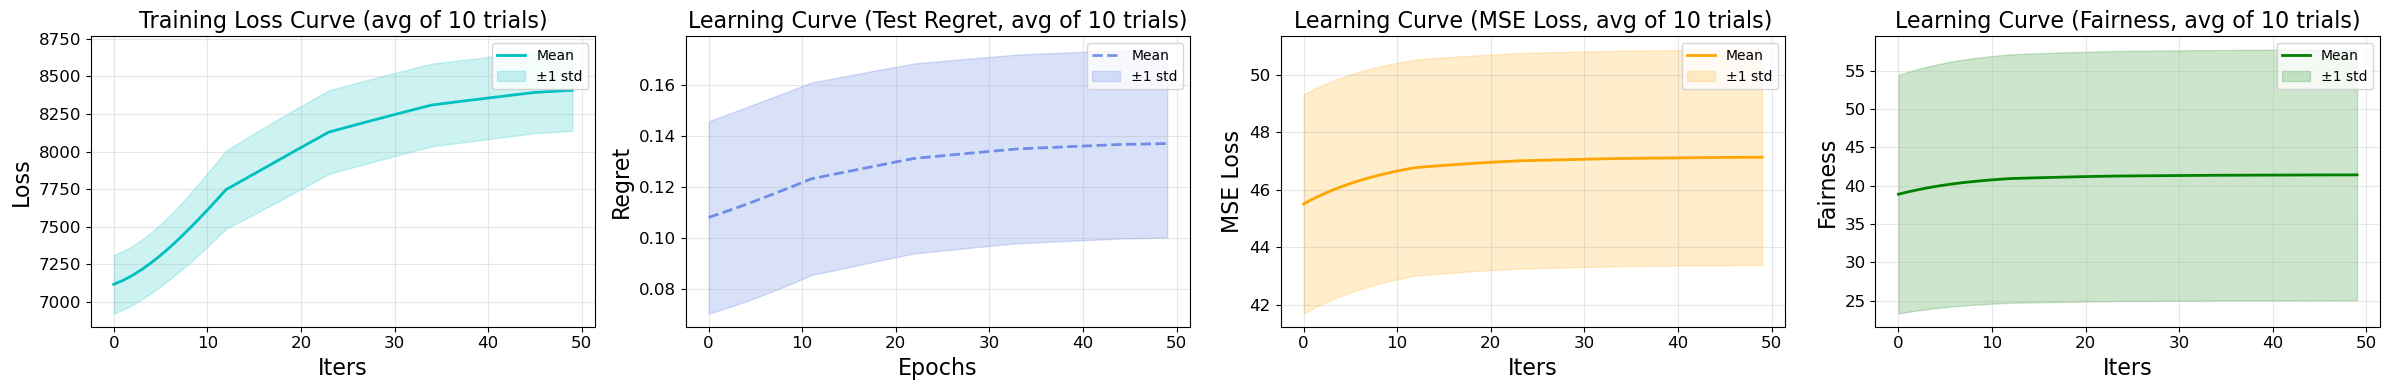

In [26]:
results_dfl_with_fair = run_multiple_trials(
    optmodel=solve_closed_form,
    feats=feats,
    gainF=gainF,
    risk=risk,
    cost=cost,
    df=df,
    n_trials=10,
    lambda_fairness=1,
    num_epochs=50,
    initial_lr=2e-3,
    weight_decay=1e-4,
    scheduler_patience=10,
    scheduler_factor=0.5,
    min_lr=1e-4,
    alpha=alpha,
    Q=Q,
    dfl=True,
    grad_method='closed_form'
)



# This is the results for `fair prediction` with `DFL` using `purturbed solution / risk gradients` with `lambda_fairness`=0


Running trial 1/10
Epoch 00012: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00023: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00034: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00045: reducing learning rate of group 0 to 1.2500e-04.

Running trial 2/10
Epoch 00013: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00024: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00035: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00046: reducing learning rate of group 0 to 1.2500e-04.

Running trial 3/10
Epoch 00013: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00024: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00035: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00046: reducing learning rate of group 0 to 1.2500e-04.

Running trial 4/10
Epoch 00035: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00046: reducing learning rate of group 0 to 5.0000e-04.

Running trial 5/10
Epoch 00012: reducing learning r

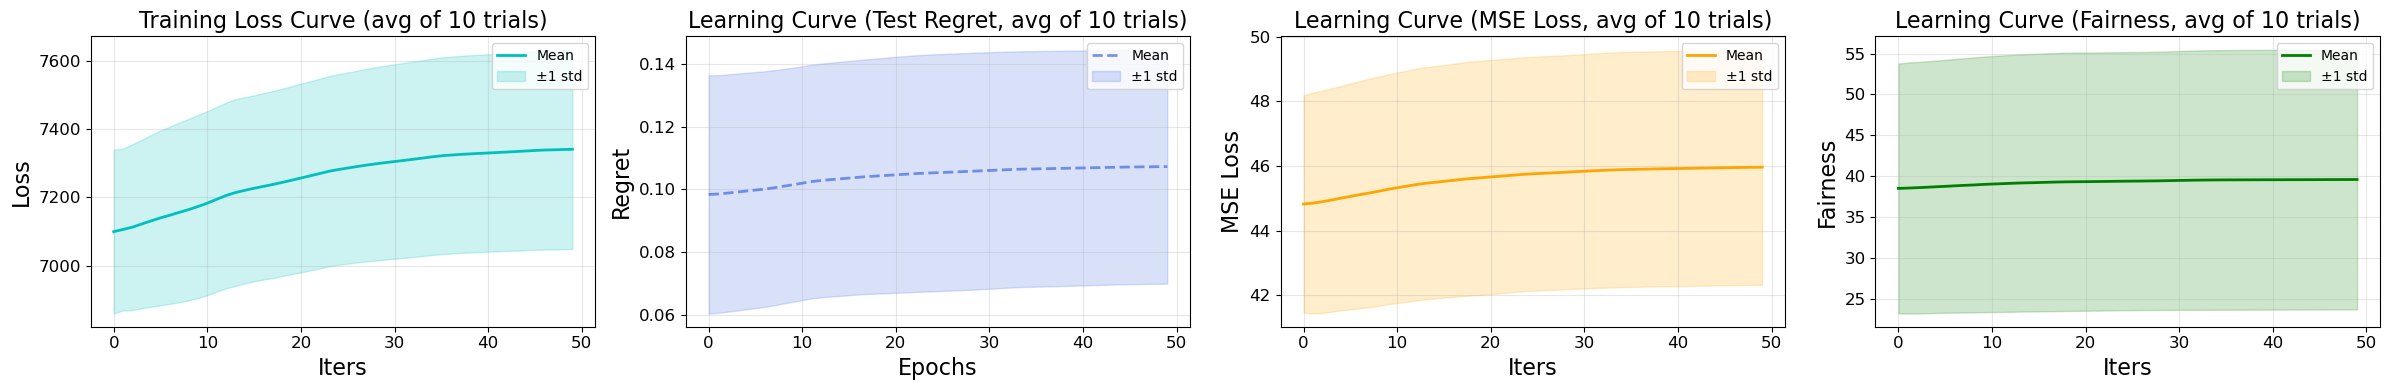

In [27]:
results_dfl_with_fair_fin_diff_1 = run_multiple_trials(
    optmodel=solve_closed_form,
    feats=feats,
    gainF=gainF,
    risk=risk,
    cost=cost,
    df=df,
    n_trials=10,
    lambda_fairness=0,
    num_epochs=50,
    initial_lr=2e-3,
    weight_decay=1e-4,
    scheduler_patience=10,
    scheduler_factor=0.5,
    min_lr=1e-4,
    alpha=alpha,
    Q=Q,
    dfl=True,
    grad_method='finite_difference_2'
)


In [28]:
results_dfl_with_fair_fin_diff_1

{'mean_train_loss': array([7099.61503906, 7105.92983398, 7112.67392578, 7122.04433594,
        7131.11943359, 7140.03920898, 7147.7206543 , 7156.07749023,
        7164.23305664, 7173.35073242, 7183.13540039, 7194.5046875 ,
        7205.66308594, 7214.30869141, 7220.82963867, 7226.98999023,
        7232.50927734, 7238.03916016, 7244.22329102, 7250.55361328,
        7257.07382812, 7263.59594727, 7270.17978516, 7276.87631836,
        7282.03691406, 7286.39008789, 7290.83579102, 7294.94819336,
        7298.74838867, 7302.26005859, 7305.53334961, 7308.74897461,
        7312.16484375, 7315.63305664, 7319.28496094, 7322.36445313,
        7324.41704102, 7326.3628418 , 7327.88393555, 7329.33945312,
        7330.62973633, 7332.0043457 , 7333.4394043 , 7334.90449219,
        7336.48569336, 7337.97670898, 7339.2253418 , 7340.00146484,
        7340.81201172, 7341.50800781]),
 'mean_test_regret': array([0.09835753, 0.09850744, 0.09879624, 0.09911463, 0.0994497 ,
        0.09976294, 0.10008494, 0.100

# This is the results for `fair prediction` with `DFL` using `purturbed objective value / risk gradients` with `lambda_fairness`=1 


Running trial 1/10
Epoch 00012: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00023: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00034: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00045: reducing learning rate of group 0 to 1.2500e-04.

Running trial 2/10
Epoch 00012: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00023: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00034: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00045: reducing learning rate of group 0 to 1.2500e-04.

Running trial 3/10
Epoch 00012: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00023: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00034: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00045: reducing learning rate of group 0 to 1.2500e-04.

Running trial 4/10
Epoch 00038: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00049: reducing learning rate of group 0 to 5.0000e-04.

Running trial 5/10
Epoch 00012: reducing learning r

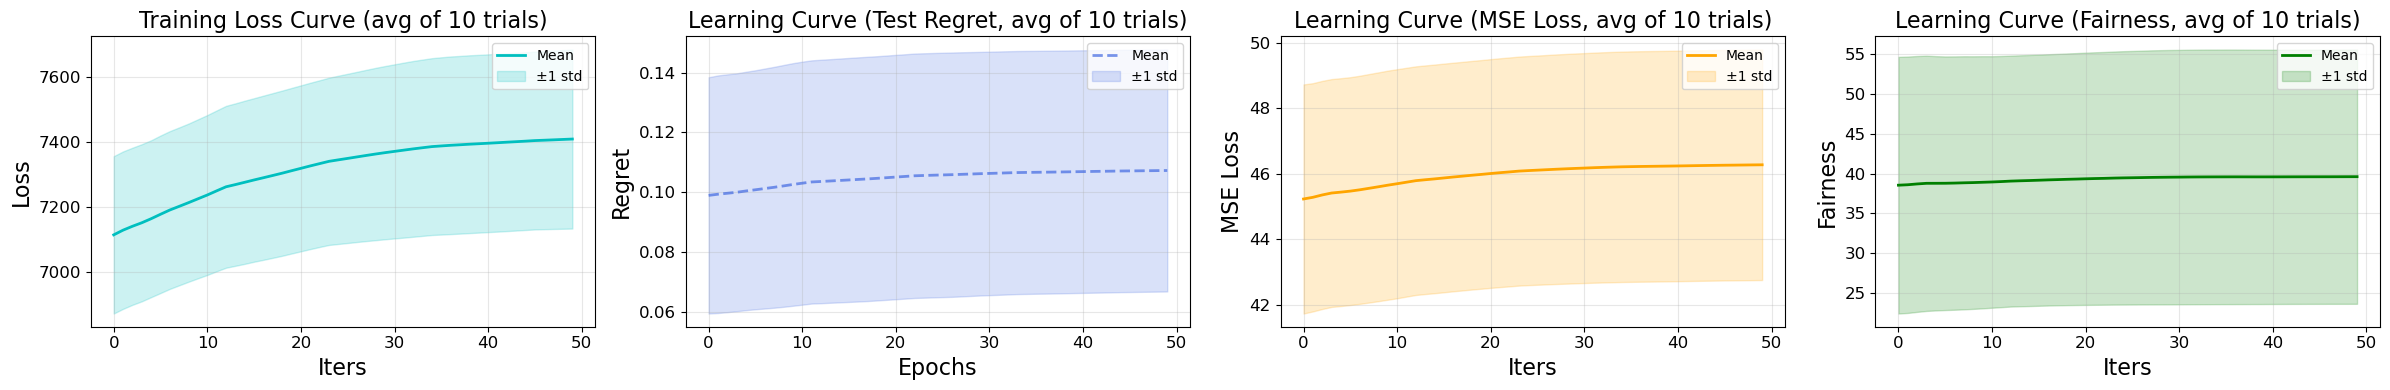

In [29]:
results_dfl_with_fair_fin_diff_2 = run_multiple_trials(
    optmodel=solve_closed_form,
    feats=feats,
    gainF=gainF,
    risk=risk,
    cost=cost,
    df=df,
    n_trials=10,
    lambda_fairness=1,
    num_epochs=50,
    initial_lr=2e-3,
    weight_decay=1e-4,
    scheduler_patience=10,
    scheduler_factor=0.5,
    min_lr=1e-4,
    alpha=alpha,
    Q=Q,
    dfl=True,
    grad_method='finite_difference_2'
)


# This is the result for comparing solver and closed form solution time


Running trial 1/1

All trials completed in 1.02 seconds
Mean trial time: 1.02 ± 0.00 seconds


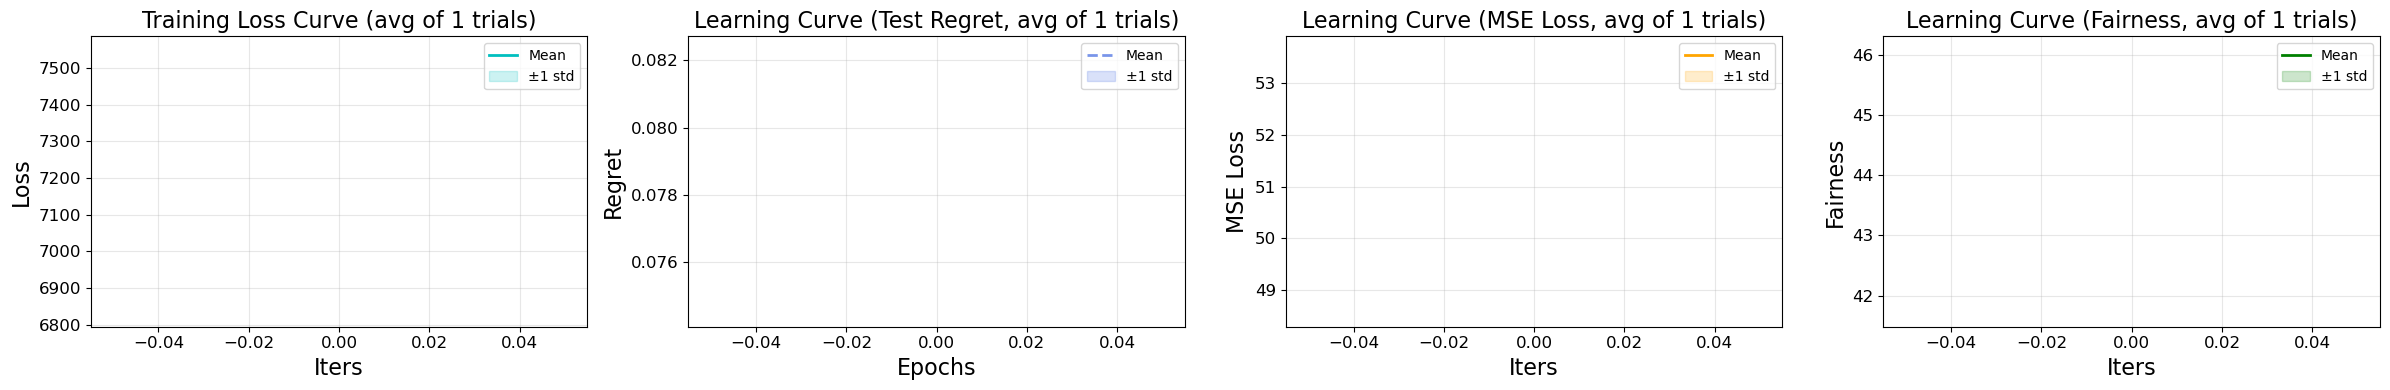

In [30]:
time_results_findiff_solver = run_multiple_trials(
    optmodel=solve_closed_form,
    feats=feats,
    gainF=gainF,
    risk=risk,
    cost=cost,
    df=df,
    n_trials=1,
    lambda_fairness=0,
    num_epochs=1 ,
    initial_lr=2e-3,
    weight_decay=1e-4,
    scheduler_patience=10,
    scheduler_factor=0.5,
    min_lr=1e-4,
    alpha=alpha,
    Q=Q,
    dfl=True,
    grad_method='finite_difference_2'
)



Running trial 1/1

All trials completed in 0.05 seconds
Mean trial time: 0.05 ± 0.00 seconds


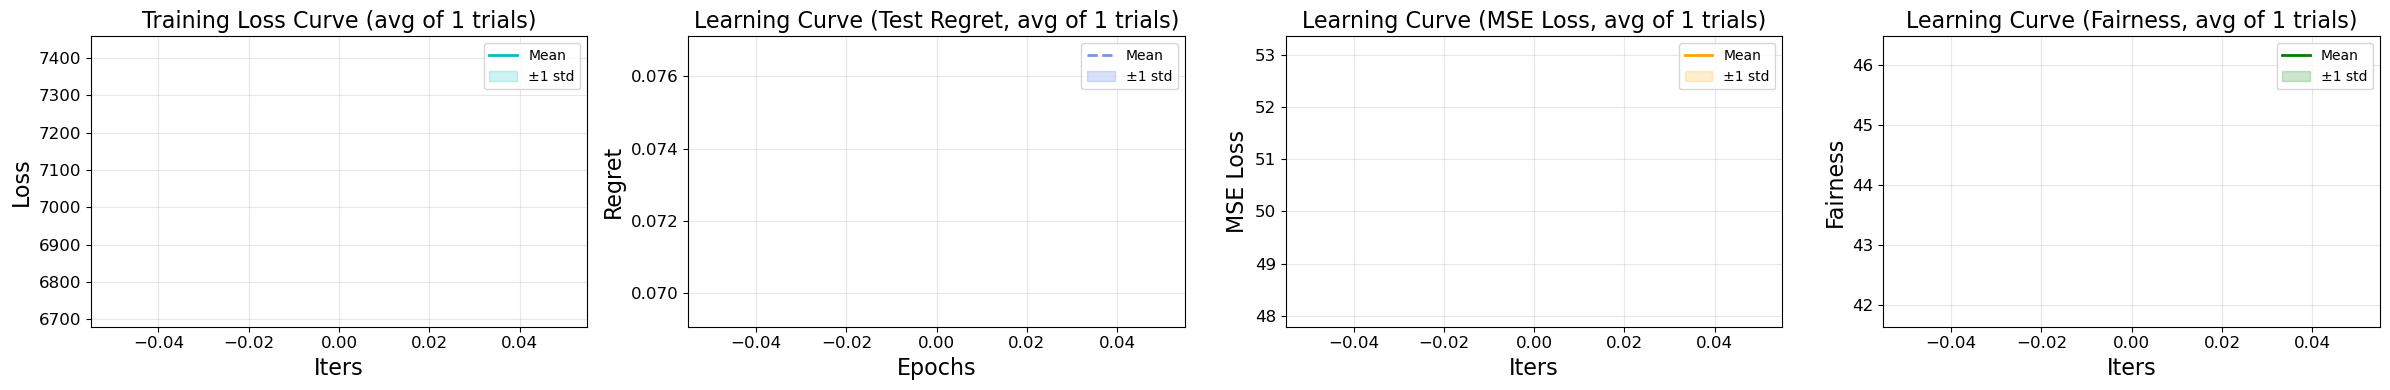

In [31]:
time_results_findiff_cf = run_multiple_trials(
    optmodel=solve_closed_form,
    feats=feats,
    gainF=gainF,
    risk=risk,
    cost=cost,
    df=df,
    n_trials=1,
    lambda_fairness=0,
    num_epochs=1,
    initial_lr=2e-3,
    weight_decay=1e-4,
    scheduler_patience=10,
    scheduler_factor=0.5,
    min_lr=1e-4,
    alpha=alpha,
    Q=Q,
    dfl=True,
    grad_method='closed_form'
)


In [32]:
results_pfl_no_fair
results_pfl_with_fair
results_dfl_no_fair
results_dfl_with_fair
results_dfl_with_fair_fin_diff_1
results_dfl_with_fair_fin_diff_2
time_results_findiff_solver
time_results_findiff_cf

{'mean_train_loss': array([7069.21484375]),
 'mean_test_regret': array([0.07309104]),
 'mean_test_mse': array([50.57338333]),
 'mean_test_fair': array([44.05532074]),
 'std_train_loss': array([0.]),
 'std_test_regret': array([0.]),
 'std_test_mse': array([0.]),
 'std_test_fair': array([0.]),
 'total_times': 0.048900604248046875,
 'mean_time': 0.048900604248046875,
 'std_time': 0.0,
 'all_train_time': [0.048900604248046875]}

In [ ]:
import pickle

# List of dictionaries to store
dicts_to_store = {
    'results_pfl_no_fair': results_pfl_no_fair,
    'results_pfl_with_fair': results_pfl_with_fair,
    'results_dfl_no_fair': results_dfl_no_fair,
    'results_dfl_with_fair': results_dfl_with_fair,
    'results_dfl_with_fair_fin_diff_1': results_dfl_with_fair_fin_diff_1,
    'results_dfl_with_fair_fin_diff_2': results_dfl_with_fair_fin_diff_2,
    'time_results_findiff_solver': time_results_findiff_solver,
    'time_results_findiff_cf': time_results_findiff_cf
}
import os
os.makedirs('res/alpha-09-model2', exist_ok=True)



# Store dictionaries to local files
for name, data in dicts_to_store.items():
    with open(f'res/alpha-05-model2/{name}.pkl', 'wb') as f:
        pickle.dump(data, f)

# Load dictionaries from local files
loaded_dicts = {}
for name in dicts_to_store.keys():
    with open(f'res/alpha-05-model2/{name}.pkl', 'rb') as f:
        loaded_dicts[name] = pickle.load(f)

# Access loaded dictionaries
results_pfl_no_fair_loaded = loaded_dicts['results_pfl_no_fair']
results_pfl_with_fair_loaded = loaded_dicts['results_pfl_with_fair']
results_dfl_no_fair_loaded = loaded_dicts['results_dfl_no_fair']
results_dfl_with_fair_loaded = loaded_dicts['results_dfl_with_fair']
results_dfl_with_fair_fin_diff_1_loaded = loaded_dicts['results_dfl_with_fair_fin_diff_1']
results_dfl_with_fair_fin_diff_2_loaded = loaded_dicts['results_dfl_with_fair_fin_diff_2']
time_results_findiff_solver_loaded = loaded_dicts['time_results_findiff_solver']
time_results_findiff_cf_loaded = loaded_dicts['time_results_findiff_cf']

: 

In [ ]:
time_results_findiff_solver, time_results_findiff_cf

({'mean_train_loss': array([383342.6875]),
  'mean_test_regret': array([16.16029167]),
  'mean_test_mse': array([51.28242111]),
  'mean_test_fair': array([0.00475574]),
  'std_train_loss': array([0.]),
  'std_test_regret': array([0.]),
  'std_test_mse': array([0.]),
  'std_test_fair': array([0.]),
  'total_times': 912.3255391120911,
  'mean_time': 912.3255391120911,
  'std_time': 0.0,
  'all_train_time': [912.3255391120911]},
 {'mean_train_loss': array([59845.17578125]),
  'mean_test_regret': array([14.74270439]),
  'mean_test_mse': array([51.29411316]),
  'mean_test_fair': array([0.00810409]),
  'std_train_loss': array([0.]),
  'std_test_regret': array([0.]),
  'std_test_mse': array([0.]),
  'std_test_fair': array([0.]),
  'total_times': 0.5036752223968506,
  'mean_time': 0.5036752223968506,
  'std_time': 0.0,
  'all_train_time': [0.5036752223968506]})

In [ ]:
912.3255391120911 / 0.5036752223968506

1811.3369459998191

In [ ]:
results_pfl_no_fair,results_pfl_with_fair

({'mean_train_loss': array([61899.86601562, 58625.72421875, 55775.0453125 , 53259.07421875,
         50929.76328125, 49121.52539062, 47305.63320312, 45948.86875   ,
         44538.23828125, 43381.32148438, 42399.39375   , 41512.28730469,
         40668.04785156, 40032.11035156, 39315.81074219, 38750.43027344,
         38219.30058594, 37844.79121094, 37361.48496094, 37120.95566406,
         36707.31035156, 36525.01699219, 36164.63339844, 35976.65839844,
         35798.70410156, 35581.09472656, 35482.85410156, 35368.55058594,
         35300.203125  , 35200.12265625, 35173.03417969, 35130.47949219,
         35213.84160156, 35226.30644531, 35414.0484375 , 35503.67324219,
         35782.50214844, 35958.87597656, 36277.21816406, 36605.60019531]),
  'mean_test_regret': array([15.65369415, 14.85048037, 14.14223118, 13.51143064, 12.9560236 ,
         12.46513777, 12.0345561 , 11.64804907, 11.30642471, 11.00932865,
         10.7393033 , 10.50256233, 10.29450626, 10.10754576,  9.93866205,
       

In [ ]:
results_dfl_no_fair,results_dfl_with_fair

({'mean_train_loss': array([61815.31210938, 57260.70234375, 53251.80742187, 50105.22734375,
         47264.94648438, 44551.88632813, 42062.03671875, 40112.93144531,
         38164.03457031, 36343.82324219, 34674.39863281, 33033.84355469,
         31714.34199219, 30456.47128906, 29377.8       , 28644.47617188,
         27382.33105469, 26778.56757812, 26349.16542969, 25944.43691406,
         25879.74140625, 25687.94433594, 26118.79667969, 26682.58261719,
         27142.33398438, 28308.92773438, 29930.30292969, 31250.27617188,
         33037.44296875, 35786.64257812, 38013.396875  , 39954.096875  ,
         39857.68710938, 38478.24179688, 36622.68867188, 34777.95976562,
         33336.48632812, 32004.23203125, 30334.784375  , 29064.24667969]),
  'mean_test_regret': array([15.19075813, 14.0117547 , 12.98718166, 12.07768669, 11.26354942,
         10.529461  ,  9.84023104,  9.18408375,  8.56477909,  7.97378087,
          7.41055646,  6.88218098,  6.38843112,  5.92607079,  5.49193897,
       

In [ ]:
results_dfl_with_fair_fin_diff_1,results_dfl_with_fair_fin_diff_2,

({'mean_train_loss': array([61822.98867187, 59478.10117188, 57311.86523438, 55533.22148437,
         54202.43085938, 52710.99257812, 51583.61953125, 50279.71640625,
         48905.21953125, 47769.05195313, 46615.32109375, 45338.48046875,
         44288.30976563, 43079.8296875 , 41831.76953125, 41217.99277344,
         40032.42089844, 39128.92480469, 38208.48574219, 37360.16152344,
         36855.94121094, 36193.74726563, 35394.128125  , 34745.06640625,
         34181.36464844, 33895.27929688, 33434.51445312, 33030.73222656,
         32949.52382812, 32769.52382812, 32821.39355469, 32818.46347656,
         33333.4421875 , 33875.12949219, 33659.99628906, 34341.6265625 ,
         34736.44238281, 34996.0765625 , 34319.35917969, 34361.01386719]),
  'mean_test_regret': array([15.86041307, 15.19433355, 14.64692011, 14.1711525 , 13.70822515,
         13.28742371, 12.83646021, 12.40487022, 11.98084831, 11.5925066 ,
         11.19010172, 10.78653555, 10.37336845,  9.98232093,  9.61134448,
       